## Rewiring Effects

This experiment uses the graph based epidemiology and contact tracing model, the BHES* Model.

[[/* Benthall, Hatna, Epstein, and Strandburg -- we can give this a different ordering or name]]

This experiment looks specifically at the interaction between:
 - the *local density* function for contact tracing probability, and
 - the rewiring rate of the Watts Strogatz graph generation algorithm
 
 Specifically, this experiment will assume the local density function for contact tracing probability and look at effects of the rewiring rate on disease spread. Secondarily, it will look at the effect of varying adoption rate under certain otherwise fixed parameters.
 
 
 ### Narratives
 
 This model makes many simplifying assumptions. Many of hese ar generic to the BHES model. 
 
 Narratives/motivations that are specific to this experiment are:
 
 #### Local density for tracing probability
 
 We set the tracing probability of an edge to be proportion of the edge's node's common neighbors to the total neighbors.

$$c_{u,v} = \frac{| N(u) \cap N(v) |}{| N(u) \cup N(v) |}$$

This reflects the idea that when a person is part of a densely connected group, their contacts with others in the group are widely known and not private. But when the peson interacts with somebody who is not part of a larger group, that connection is likely unknown. Revealing this connection through a contact tracing system might be an invasion of privacy.

Example narratives:

* A person is a member of a large and close-knit family. They have an affair or liason with somebody in a different family.
* A person is an employee of a company where coworkers frequently meet. They take time off of work, saying that it is for a sick day. But really they are interviewing for another job.

We assume that for these kinds of contacts, the person is more likely to turn of their contact tracing app.

#### Watts-Strogatz Rewiring

The Watts-Strogatz model is designed to be a simple model that has triadic closure and local clustering on par with actually observed social networks.

It starts with a ring lattice of $N$ nodes with each node connected to $K$ neighbors. Then it rewires each edge with probability $\beta$. As $\beta$ approaches $1$, the network gets close to an Erods-Renyi graph $G(N,p)$ with $p = \frac{K}{N - 1}$.

Varying this $\beta$ parameter is motivate by the following narratives:
 * As the population is under "lockdown", people choose the most important contacts in their life and restrict their interactions to them. While the whole population is connected (via the ring lattice structure), they do not integrate much with other people outside their local community.
 * Easing the "lockdown", people are more able to interact with other parts of the network and take advantage of the social exchange opportunities available from looking outside one's network.
 
 
 ### A priori considerations and concerns
 
 The local density function, combined with the Watts Strogatz model, will assign contract tracing probabilites $c_{i,j}$ as a decreasing function of $abs(i - j)$ for low rewiring rates. Around the circle lattice, close neighbors will have high tracing probabilities. Distance neighbors will have fewer shared connections.
 
 Rewired edges will have especially low tracing probabilities because unless there are collisions between edge rewirings, which are probabilistically rare, the ends of the rewired edges will share no local neighbors.
 
 This amounts to strong assumptions about the viability of the contact tracing system. It will perhaps be effective at stopping spreading in the more densly knit circle lattice structure, but it will be ineffective at detecting spreads across rewired edges.
 
So:
 * We should see contact tracing performance reduced dramatically as $\beta$ increases *due to the drop in $C$*.
 * It may be difficult to distinguish this effect from the change due to network topology itself, which may have an effect on the disease spread independent of the contact tracing system. (or, with a constant $C$.)
 
 

In [1]:
import sys

sys.path.append('.')

import model

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import seaborn as sns
import statistics

## Experiment 1: Varying rewiring rate



In [3]:
## Population parameters:
params = {
    # Node parameter
    'A' : .7, # probability of adoption
    
    # Edge parameter
    'W' : model.expected_one_per_edge, # probability of edge activation
    'C' : model.local_density,
    
    ## Disease parameters

    'beta_hat' : 1, # probability of transmission upon contact
    'alpha' : .25, # probability of exposed becoming infectious
    'gamma' : .1, # probability of infectious becoming recovered
    'zeta' : .1, # probability of infectious becoming symptomatic

    ## Contact tracing parameters

    'limit' : 10, # number of time steps the contact tracing system remembers
}

In [4]:
def watts_strogatz_case(beta):
    g = nx.watts_strogatz_graph(1500, 10, beta)
    p = params.copy()
    
    return g, p

In [5]:
conditions = {
    'beta-.000' : {'beta' : 0.000},
    'beta-.005' : {'beta' : 0.005},
    'beta-.010' : {'beta' : 0.010},
    'beta-.015' : {'beta' : 0.015},
    'beta-.020' : {'beta' : 0.020},
}

In [6]:
runs = 30

results = model.experiment(
    watts_strogatz_case,
    conditions,
    runs)

beta-.000
Trial 0
Trial 12 hits time step 100
beta-.005
Trial 0
Trial 0 hits time step 100
Trial 14 hits time step 100
beta-.010
Trial 0
Trial 0 hits time step 100
Trial 0 hits time step 200
Trial 2 hits time step 100
Trial 6 hits time step 100
Trial 10 hits time step 100
Trial 13 hits time step 100
Trial 16 hits time step 100
Trial 19 hits time step 100
Trial 20 hits time step 100
Trial 26 hits time step 100
beta-.015
Trial 0
Trial 2 hits time step 100
Trial 6 hits time step 100
Trial 8 hits time step 100
Trial 12 hits time step 100
Trial 12 hits time step 200
Trial 12 hits time step 300
Trial 13 hits time step 100
Trial 18 hits time step 100
Trial 18 hits time step 200
Trial 19 hits time step 100
Trial 20 hits time step 100
Trial 22 hits time step 100
Trial 25 hits time step 100
Trial 25 hits time step 200
Trial 27 hits time step 100
Trial 28 hits time step 100
Trial 29 hits time step 100
beta-.020
Trial 0
Trial 0 hits time step 100
Trial 1 hits time step 100
Trial 1 hits time step 2

Plotting the final susceptible rate

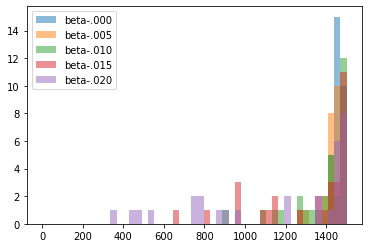

In [10]:
g = results['beta-.000'][0][1]
bins = np.linspace(0, len(g.nodes()), 50)

for case in results:
    plt.hist(
        [len(model.susceptible(r[1]))
         for r
         in results[case]],
        bins,
        alpha=.5,
        label=case)
    
plt.legend()

In [11]:
def average_susceptible_over_time(records):
    s_records = [r[3] for r in records]
    
    m = max([len(d) for d in s_records])

    s_plus = [d + [d[len(d)-1]] * (m - len(d)) for d in s_records]

    return [
        statistics.mean([d[i] for d in s_plus])
        for i
        in range(m)
    ]

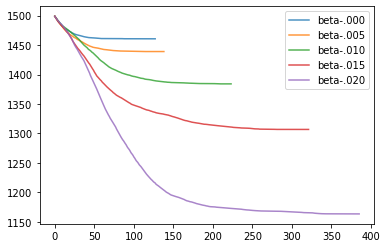

In [13]:
g = results['beta-.000'][0][1]
bins = np.linspace(0, len(g.nodes()), 50)

for case in results:
    plt.plot(
        model.average_susceptible_over_time(results[case]),
        alpha=.8,
        label=case)
    
plt.legend()